Aim: 
Make easy-peasy non spatial random forest model
- Calibate model
- tune hyperparameters
- Evaluate performance

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt

from scipy import stats, optimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_coords.xlsx")

df_candidates = gpd.GeoDataFrame(df_candidates, crs="EPSG:4326", geometry=gpd.points_from_xy(df_candidates.lat, df_candidates.lon))
df_candidates.tail(2)

,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_business,shp_damage_level_products,shp_closed_d,shp_duration_back2normal,contaminations,...,elevation_building_height_cm,building_elevation_rel2surrounding,building_elevation_rel2surrounding.cm,shp_sector.specify,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_monetary_resources_prenvention,lat,lon,geometry
502,2.0,70.0,2.0,10,0.0,4,2,2,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
503,0.0,100.0,5.0,20,0.0,1,1,14,20,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY


In [24]:
# ## remove businesses without direct damage costs

# df_candidates.Target_direct.value_counts();
# df_candidates = df_candidates[df_candidates.Target_direct > 0.0]  # 136=0.0
# print(df_candidates.shape)


## workaround due nan- cols from df_num or df_agg 
df_candidates = df_candidates[[c for c in df_candidates if df_candidates[c].isnull().sum() < 100]]
#df_candidates.isna().sum()
df_candidates = df_candidates.fillna(0)

Target_direct                0
business_reduction           0
inundation_duration_h        0
water_depth_cm               0
warning_time_h               0
shp_damage_level_business    0
shp_damage_level_products    0
shp_closed_d                 0
shp_duration_back2normal     0
contaminations               0
emergency_measures           0
geometry                     0
dtype: int64

In [46]:
y = df_candidates.Target_direct.astype("int64")
X = df_candidates.drop(["Target_direct",
                        #"shp_sector.specify",   # fix this variable and make as numerbs
                        #"Q0.1",
                        "geometry"#,"lat","lon"
                        ], axis=1)

# scaler = MinMaxScaler() 
# X = scaler.fit_transform(X_unscaled.reshape(-1, 1))


### Discretized continous variabels: 
E.g. by an equal frequency discretization
use coarse discrete classes for each varible e.g. 5 classes used in Can ho City-DS

In [47]:
#X['shp_sector.specify'] = X[''shp_sector.specify'].map({'no':0,'yes':1,'unknown':0})


### split into train and test set
- Normalization not needed, is optional


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Train and tune model

In [49]:
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [52]:
### tunning of hyperparamters by RandomizedSearchCV
param_dist = {'n_estimators': [10, 100,200, 500],
              'max_depth': randint(1, 3, 5, 10,20)}


TypeError: _parse_args() takes from 3 to 4 positional arguments but 6 were given

In [ ]:
randomized_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the model by randomizedSearchCV
randomized_search.fit(X_train, y_train)

c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000012DF0972370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000012DEE642460>})

In [53]:
y_pred = model.predict(X_test)


### Evaluation

In [54]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7326732673267327


### Feautre importance

In [89]:
importances = model.feature_importances_
#importances = np.sort(importances)#[:10]

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances) #  reverse sort[::-1]


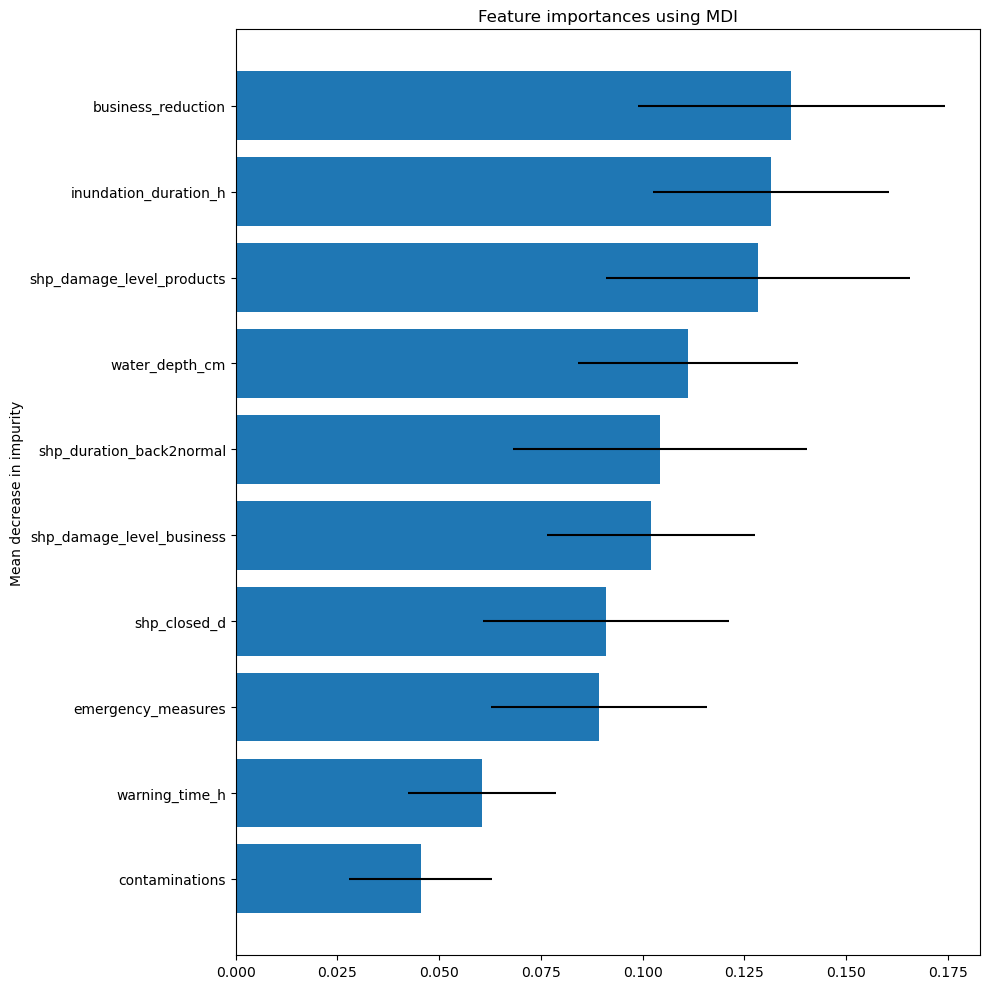

In [92]:
fig, ax = plt.subplots(figsize=(10,10))

plt.barh(range(len(indices)), importances[indices], align='center',  xerr=std[indices])
plt.yticks(range(len(indices)), np.array(X.columns)[indices])
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#  fig, ax = plt.subplots(figsize=(10,10))
# num_features = X.shape[1]
# forest_importances.plot.bar(range(X.shape[1]), importances[indices], yerr=std[indices]) # yerr=std, ax=ax,
# #forest_importances.plot.barh(range(X.shape[1]), importances[indices[-num_features:]], align='center')#,  yerr=std[indices])


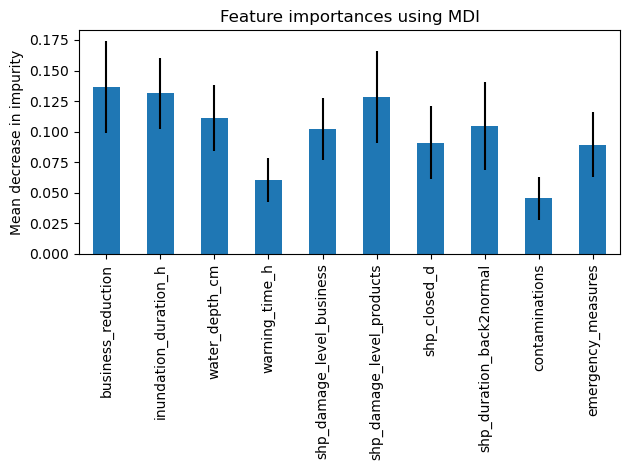

In [79]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()